<center>
<h1 style="font-family:verdana">
 💻 🧑 Reconeixement d'entitats anomenades 🧑 💻




<p style="font-size:16px;"> Pràctica 2 </p>
<p style="font-size:14px;"> Paula Justo i Júlia Pedrol </p>
<p style="font-size:14px;"> 3r GIA - TVD </p>

<p> 🎯 <b>Objectiu</b>: en aquesta segona part de la pràctica aprendrem a reconèixer entitats anomenades, és a dir, identificar i classificar entitats en una oració que poden ser (en el context de reserva de vols) la ciutat de sortida o d'arribada, la data del mes i el dia, si es de negocis o turista o altres categories específiques. Aquesta tasca se sol plantejar etiquetant cada paraula amb una etiqueta de la categoria de l'entitat a la qual correspon.

Tant la classificació d'intencions (tasca estudiada a la primera part) com el reconeixement d'entitats anomenades (Name Entity Recognition, NER) que veurem en aquesta part són components crucials dels sistemes de processament del llenguatge natural (Natural Language Processing, NLP) i sovint s'utilitzen junts per crear aplicacions d'intel·ligència artificial (IA) conversacionals més sofisticades. Per exemple, en un xatbot, la classificació d'intencions ajuda a entendre la intenció principal de l'usuari, mentre que el reconeixement d'entitats anomenades ajuda a extreure entitats rellevants per proporcionar respostes més contextualitzades.


<p> ✨ <b>Contingut</b>: els passos d'aquesta segona part seran similars a la primera. En primer lloc, analitzarem el conjunt de dades. En segon lloc, prepararem les dades per a poder entrenar el model. I finalment dissenyarem l'arquitectura i entrenarem el model. </p>


<p> ✏ <b>Exercicis</b>: en cada secció anireu trobant exercicis que haureu d'anar resolent. </p>

---

<h2> Índex </h2>

1. [Inspecció del conjunt de dades](#section-one)
  * [Exercici 1](#ex-one)
  * [Exercici 2](#ex-two)
2. [Preprocessament de dades](#section-two)
  * [Exercici 3](#ex-three)
  * [Exercici 4](#ex-four)
3. [Disseny del model i entrenament](#section-three)
  * [Exercici 5](#ex-five)
  * [Exercici 6](#ex-six)
4. [Lliurable](#section-four)

---

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report


<h1><a name="section-one"> 1. Inspecció del conjunt de dades </a></h1>

In [ ]:
!pip install gdown
!gdown "https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t"
!tar -zxf nlu_ATIS_data.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t
To: /content/nlu_ATIS_data.tar.gz
100% 122k/122k [00:00<00:00, 3.20MB/s]


In [ ]:
!ls data

test.csv  train.csv


En aquesta segona part de la pràctica utilitzarem el mateix dataset que a la primera part, però en aquest cas utilitzarem la **primera columna** que correspon a les **oracions** introduïdes pels usuaris i la **segona columna** on trobarem les oracions d'entrada en format **BILOU**.

El format BILOU  és un esquema d'etiquetatge que es fa servir a les tasques de reconeixement d'entitats anomenades. El nom *BILOU* representa les etiquetes utilitzades en aquest esquema:

*   **B** - Beginning: primer token d'una entitat.
*   **I** - Inside: token dins d'una entitat.
*   **L** - Last: últim token de l'entitat.
*   **O** - Outside: token que no pertany a cap entitat.
*   **U** - Unit: entitats d'un sol token

A continuació, carregarem les dades per visualitzar i poder entendre millor aquestes etiquetes.

---

 <h1><a name="ex-one"><center> ✏ Exercici 1 ✏</a></h1>

A continuació us demanem que carregueu els dos CSVs de la carpeta `data`: `train.csv`, `test.csv` utilitzant pandas. Recorda que aquests CSVs no tenen capçalera. Agafeu les 900 últimes lineas del fitxer `train.csv` per crear un dataframe per validació.

In [ ]:
train_data = pd.read_csv('./data/train.csv', header=None)
val_data = train_data.tail(900)
train_data = pd.read_csv('./data/train.csv', header=None, nrows=4078)
test_data = pd.read_csv('./data/test.csv', header=None)

print('Training size:', len(train_data))
print('Validation dataset size:', len(val_data))
print('Test dataset size:', len(test_data))

Training size: 4078
Validation dataset size: 900
Test dataset size: 893


In [ ]:
test_data

,0,1,2
0,i would like to find a flight from charlotte t...,"""O O O O O O O O B-fromloc.city_name O B-tolo...","""flight"""
1,on april first i need a ticket from tacoma to ...,"""O B-depart_date.month_name B-depart_date.day...","""airfare"""
2,on april first i need a flight going from phoe...,"""O B-depart_date.month_name B-depart_date.day...","""flight"""
3,i would like a flight traveling one way from p...,"""O O O O O O B-round_trip I-round_trip O B-fr...","""flight"""
4,i would like a flight from orlando to salt lak...,"""O O O O O O B-fromloc.city_name O B-toloc.ci...","""flight"""
...,...,...,...
888,please find all the flights from cincinnati to...,"""O O O O O O B-fromloc.city_name O O O O O B-...","""flight"""
889,find me a flight from cincinnati to any airpor...,"""O O O O O B-fromloc.city_name O O O O O B-to...","""flight"""
890,i 'd like to fly from miami to chicago on amer...,"""O O O O O O B-fromloc.city_name O B-toloc.ci...","""flight"""
891,i would like to book a round trip flight from ...,"""O O O O O O B-round_trip I-round_trip O O B-...","""flight"""


---

 <h1><a name="ex-two"><center> ✏ Exercici 2 ✏</a></h1>

Tal com hem introduït abans, per a aquest exercici ens centrarem en la **primera** i la **segona** columna. Per tant, ara us demanem que guardeu en les següents variables, les llistes corresponents a les oracions i a les etiquetes de les tres particions (`train`, `validation` i `test`).

In [ ]:
# Train
train_sentences = list(train_data[0])
train_labels = list(s.replace('"', '') for s in train_data[1])


# Validation
val_sentences = list(val_data[0])
val_labels = list(s.replace('"', '') for s in val_data[1])


# Test
test_sentences = list(test_data[0])
test_labels = list(s.replace('"', '') for s in test_data[1])

print(f"train: {len(train_sentences)} | val: {len(val_sentences)} | test: {len(test_sentences)}")

train: 4078 | val: 900 | test: 893


---

Si tot ha anat bé ja podem analitzar quin aspecte té el format BILOU.

In [ ]:
print(train_sentences[0])
print(train_labels[0])

i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
 O O O O O B-fromloc.city_name O B-depart_time.time I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O B-arrive_time.period_of_day


Aquest hauria de ser el resultat obtingut si executeu la cel·la anterior:

```


i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
 "O O O O O B-fromloc.city_name O B-depart_time.time I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O B-arrive_time.period_of_day"


```

En aquest exemple, `boston` i `838 am` corresponen a l'entitat "ciutat de sortida" i a l'entitat "hora de sortida" respectivament (`fromloc.city_name`,`depart_time.time`). `838` correspon al primer token que pertany la entitat `depart_time.time` i `am` al segon de la mateixa entitat. Els tokens com `i` o `want` no pertanyen a cap entitat.

In [ ]:
print(train_sentences[1])
print(train_labels[1])

what flights are available from pittsburgh to baltimore on thursday morning
 O O O O O B-fromloc.city_name O B-toloc.city_name O B-depart_date.day_name B-depart_time.period_of_day


I aquest hauria de ser el resultat de la cel·la anterior:

```
what flights are available from pittsburgh to baltimore on thursday morning
 O O O O O B-fromloc.city_name O B-toloc.city_name O B-depart_date.day_name B-depart_time.period_of_day
```

En l'anterior exemple, `what`, `flights`, `are`, `available`, `from`, `to` i `on` estan etiquetades com a no pertanyents a cap entitat. I, en canvi, `pittsburgh` pertany a l'entitat d'un sol token anomenada ciutat d'arribada (`toloc.city_name`). També hi ha entitats compostes com `baltimore` que pertany a l'entitat ciutat de sortida (`fromloc.city_name`) i `thursday morning` que pertanyen a les entitats data de sortida (`depart_date.day_name`, `depart_time.period_of_day`).

Vegem-ne la llista completa d'entitats.

In [ ]:
from collections import Counter

def count_unique_entities(list_of_label_sentences):
  flat_labels = []
  for labels in list_of_label_sentences:
    flat_labels += labels.split()
  c = Counter(flat_labels)
  return len(c), list(c.keys())

num_unique_entities, unique_entities = count_unique_entities(train_labels)

print("Number of different entities:", num_unique_entities)

print("Unique entities:", unique_entities)

Number of different entities: 119
Unique entities: ['O', 'B-fromloc.city_name', 'B-depart_time.time', 'I-depart_time.time', 'B-toloc.city_name', 'B-arrive_time.time', 'B-arrive_time.period_of_day', 'B-depart_date.day_name', 'B-depart_time.period_of_day', 'B-flight_time', 'I-flight_time', 'I-fromloc.city_name', 'B-cost_relative', 'B-round_trip', 'I-round_trip', 'B-fare_amount', 'I-fare_amount', 'B-depart_date.today_relative', 'I-toloc.city_name', 'B-city_name', 'B-stoploc.city_name', 'B-toloc.airport_code', 'B-depart_time.time_relative', 'B-class_type', 'I-class_type', 'B-depart_date.date_relative', 'B-airline_name', 'I-airline_name', 'B-arrive_time.time_relative', 'B-depart_time.start_time', 'I-depart_time.start_time', 'B-depart_time.end_time', 'I-depart_time.end_time', 'B-fromloc.airport_name', 'I-fromloc.airport_name', 'B-toloc.state_name', 'B-depart_date.day_number', 'I-depart_date.day_number', 'B-depart_date.month_name', 'B-mod', 'B-fare_basis_code', 'B-transport_type', 'B-flight_m

<h1><a name="section-two"> 2. Preprocessament de dades </a></h1>

El processament de les dades serà semblant al de la primera part d'aquesta pràctica.

---

 <h1><a name="ex-three"><center> ✏ Exercici 3 ✏</a></h1>

En aquest exercici us demanem que realitzeu els passos següents per preparar les dades.

 1. El primer pas serà construir el vocabulari a partir de les paraules presents a les oracions d'entrenament.

2. El segon pas serà convertir les oracions en seqüències de nombres enters usant el tokenitzador.

3. El tercer pas serà guardar la longitud original de cada oració. Això ens serà útil per evaluar el nostre model sense tenir en compte el padding.

3. Finalment, per aconseguir que totes les seqüències tinguen la mateixa longitud, fixarem la longitud segons la màxima trobada a l'entrenament i afegirem zeros a les oracions de menor longitud.

Recordeu que podeu consultar com fer-ho a la documentació de la llibrería:
* <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer"> Tokenizer </a>
* <a href="https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences"> Pad Sequences </a>




In [ ]:
#tokenizer = ...
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_sentences)
tokenizer = Tokenizer(filters='', lower=True)
tokenizer.fit_on_texts(train_sentences)


#train_sequences = ...
train_sequences = tokenizer.texts_to_sequences(train_sentences)

#max_sequence_length = ...
max_sequence_length = max(len(seq) for seq in train_sequences)

#len_train_sequences = ...
len_train_sequences = [len(seq) for seq in train_sequences]

#train_pad_sequences = ...
train_pad_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')

#val_sequences = ...
val_sequences = tokenizer.texts_to_sequences(val_sentences)

#len_val_sequences = ...
len_val_sequences = [len(seq) for seq in val_sequences]

#val_pad_sequences = ...
val_pad_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post')

#test_sequences = ...
test_sequences = tokenizer.texts_to_sequences(test_sentences)

#len_test_sequences = ...
len_test_sequences = [len(seq) for seq in test_sequences]

#test_pad_sequences = ...
test_pad_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

print("Nombre total de paraules al vocabulari:", len(tokenizer.word_index) + 1)
print("Longitud màxima de seqüència:", max_sequence_length)
print("Dimensió de train_pad_sequences:", train_pad_sequences.shape)
print("Dimensió de val_pad_sequences:", val_pad_sequences.shape)
print("Dimensió de test_pad_sequences:", test_pad_sequences.shape)

print("\nPrimera oració original:")
print(train_sentences[0])
print("\nSeqüència tokenitzada:")
print(train_sequences[0])
print("\nSeqüència amb padding:")
train_pad_sequences[0]


Nombre total de paraules al vocabulari: 831
Longitud màxima de seqüència: 46
Dimensió de train_pad_sequences: (4078, 46)
Dimensió de val_pad_sequences: (900, 46)
Dimensió de test_pad_sequences: (893, 46)

Primera oració original:
i want to fly from boston at 838 am and arrive in denver at 1110 in the morning

Seqüència tokenitzada:
[12, 69, 1, 38, 2, 9, 64, 415, 84, 17, 75, 16, 13, 64, 493, 16, 4, 36]

Seqüència amb padding:


array([ 12,  69,   1,  38,   2,   9,  64, 415,  84,  17,  75,  16,  13,
        64, 493,  16,   4,  36,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0], dtype=int32)

---

 <h1><a name="ex-four"><center> ✏ Exercici 4 ✏</a></h1>

Per aconseguir-ho haureu de seguir els passos següents.

 1. En primer lloc, haureu d'esbrinar quantes etiquetes diferents hi ha. Podeu prendre com a exemple la funció `count_unique_entities` per fer-ho. Tingueu en compte que haureu de modificar la funció, ja que per exemple aquesta funció considera que `B-depart_time.time`, `I-depart_time.time`, `L-depart_time.time`, `U-depart_time.time` són la mateixa entitat. En aquest exercici, necessitarem comptar-les per separat. També l'entitat O ha de ser considerada com una classe.

 2. El segon pas serà codificar les diferents classes trobades en etiquetes numèriques. Tingueu en compte que cada paraula de l'oració té una etiqueta i, per tant, per a cada oració tindrem una llista d'etiquetes. El *padding* el codificarem amb l'etiqueta corresponent a **O** (outside). Per ajudar-vos hem preparat el processament per a les etiquetes d'entrenament, intenteu comprendre el que es fa i així repetir-ho per a la partició de validació i test.

 3. Finalment, haureu de convertir les diferents classes a vectors one-hot. Recordeu de nou que per a cada oració tindrem una llista de vectors one-hot.


 Podeu consultar els apartats de la documentació:
 * <a href=https://www.tensorflow.org/guide/keras/understanding_masking_and_padding> Masking and Padding </a>

 * <a href=https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical> To Categorical </a>



In [ ]:
from collections import OrderedDict
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Pas 1: classes úniques (incloent <pad>)
def count_unique_entities(list_of_label_sentences):
    """
    Retorna (num_tags, llista_tags) incloent '<pad>' com la primera etiqueta.
    Manté B-, I-, L-, U-, O com a etiquetes diferents.
    """
    seen = OrderedDict()
    seen['<pad>'] = True

    for labels in list_of_label_sentences:
        if labels is None:
            continue
        s = str(labels).strip().replace('"', '')
        for tag in s.split():
            seen[str(tag)] = True

    unique_entities = list(seen.keys())
    return len(unique_entities), unique_entities

num_unique_entities, unique_entities = count_unique_entities(train_labels)
print("Number of different entities:", num_unique_entities)
print("Unique entities:", unique_entities)

# Helpers
def split_clean_labels(list_of_label_sentences):
    """'O O B-x ...' -> ['O','O','B-x',...] (sense cometes)."""
    return [str(s).strip().replace('"', '').split() for s in list_of_label_sentences]

def remove_sentences(list_labels, list_sequences):
    """
    Elimina oracions de val/test que continguin alguna etiqueta no vista a train.
    Manté alineats labels i sequences (sense convertir a np.array).
    """
    idx_to_remove = set()
    labels_to_remove = []
    train_tag_set = set(unique_entities)

    for idx, labels in enumerate(list_labels):
        bad = False
        for label in labels:
            if label not in train_tag_set:
                labels_to_remove.append(label)
                bad = True
        if bad:
            idx_to_remove.add(idx)

    if labels_to_remove:
        print("labels to remove:", labels_to_remove)

    labels    = [elem for i, elem in enumerate(list_labels)    if i not in idx_to_remove]
    sequences = [elem for i, elem in enumerate(list_sequences) if i not in idx_to_remove]
    return labels, sequences

# Pas 2: LabelEncoder entrenat amb TOT el set de classes (incloent <pad>)
if '<pad>' not in unique_entities:
    unique_entities = ['<pad>'] + unique_entities
elif unique_entities[0] != '<pad>':
    unique_entities.remove('<pad>')
    unique_entities = ['<pad>'] + unique_entities

label_encoder = LabelEncoder()
label_encoder.fit([str(x) for x in unique_entities])

pad_id = int(label_encoder.transform(['<pad>'])[0])

# TRAIN
_train_labels_ll = split_clean_labels(train_labels)

train_pad_sequences = pad_sequences(
    train_sequences, maxlen=max_sequence_length, padding='post', truncating='post', value=0
)

train_numerical_labels = [label_encoder.transform(seq).tolist() for seq in _train_labels_ll]
train_pad_labels = pad_sequences(
    train_numerical_labels, maxlen=max_sequence_length, padding='post', truncating='post', value=pad_id
)

num_classes = len(label_encoder.classes_)
train_labels_one_hot = to_categorical(train_pad_labels, num_classes=num_classes).astype('float32')

# VALIDATION
_val_labels_ll = split_clean_labels(val_labels)
val_labels_clean, val_sequences_clean = remove_sentences(_val_labels_ll, val_sequences)

val_pad_sequences = pad_sequences(
    val_sequences_clean, maxlen=max_sequence_length, padding='post', truncating='post', value=0
)

val_numerical_labels = [label_encoder.transform(seq).tolist() for seq in val_labels_clean]
val_pad_labels = pad_sequences(
    val_numerical_labels, maxlen=max_sequence_length, padding='post', truncating='post', value=pad_id
)

val_labels_one_hot = to_categorical(val_pad_labels, num_classes=num_classes).astype('float32')
len_val_sequences = [len(s) for s in val_sequences_clean]

# TEST
_test_labels_ll = split_clean_labels(test_labels)
test_labels_clean, test_sequences_clean = remove_sentences(_test_labels_ll, test_sequences)

test_pad_sequences = pad_sequences(
    test_sequences_clean, maxlen=max_sequence_length, padding='post', truncating='post', value=0
)

test_numerical_labels = [label_encoder.transform(seq).tolist() for seq in test_labels_clean]
test_pad_labels = pad_sequences(
    test_numerical_labels, maxlen=max_sequence_length, padding='post', truncating='post', value=pad_id
)

test_labels_one_hot = to_categorical(test_pad_labels, num_classes=num_classes).astype('float32')
len_test_sequences = [len(s) for s in test_sequences_clean]

Number of different entities: 120
Unique entities: ['<pad>', 'O', 'B-fromloc.city_name', 'B-depart_time.time', 'I-depart_time.time', 'B-toloc.city_name', 'B-arrive_time.time', 'B-arrive_time.period_of_day', 'B-depart_date.day_name', 'B-depart_time.period_of_day', 'B-flight_time', 'I-flight_time', 'I-fromloc.city_name', 'B-cost_relative', 'B-round_trip', 'I-round_trip', 'B-fare_amount', 'I-fare_amount', 'B-depart_date.today_relative', 'I-toloc.city_name', 'B-city_name', 'B-stoploc.city_name', 'B-toloc.airport_code', 'B-depart_time.time_relative', 'B-class_type', 'I-class_type', 'B-depart_date.date_relative', 'B-airline_name', 'I-airline_name', 'B-arrive_time.time_relative', 'B-depart_time.start_time', 'I-depart_time.start_time', 'B-depart_time.end_time', 'I-depart_time.end_time', 'B-fromloc.airport_name', 'I-fromloc.airport_name', 'B-toloc.state_name', 'B-depart_date.day_number', 'I-depart_date.day_number', 'B-depart_date.month_name', 'B-mod', 'B-fare_basis_code', 'B-transport_type', 'B

<h1><a name="section-three"> 3. Disseny del model i entrenament </a></h1>

---
<h1><a name="ex-five"><center> ✏ Exercici 5 ✏</a></h1>

De forma similar com féreu a la primera part de la pràctica us demanem que dissenyeu l'arquitectura i entreneu el model. Podeu fer servir una arquitectura similar. Ara bé, per capturar les dependències seqüencials podeu canviar la capa de GlobalMaxPooling1D per una LSTM.

In [ ]:
s = train_pad_labels.shape
train_flat_labels = train_pad_labels.reshape(s[0]*s[1])
train_unq_labels = np.unique(train_flat_labels)
print(train_flat_labels.shape, train_unq_labels)

(187588,) [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]


In [ ]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(ff_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        position_embeddings = self.pos_emb(positions)
        token_embeddings = self.token_emb(inputs)
        return token_embeddings + position_embeddings

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
from sklearn.metrics import classification_report

embedding_dim = 128
vocab_size    = len(tokenizer.word_index) + 1
num_classes   = len(label_encoder.classes_)

print(f"Embedding dim: {embedding_dim}, vocab_size: {vocab_size}, num_classes: {num_classes}")

# Arquitectura del model NER amb CNN
model = keras.Sequential([
    layers.Embedding(input_dim=vocab_size,
                     output_dim=embedding_dim,
                     mask_zero=True),

    # Captura context local amb filtres convolucionals
    layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
    layers.Dropout(0.2),

    layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    layers.Dropout(0.2),

    # Predicció per token
    layers.Dense(num_classes, activation='softmax')
])

# Compilació
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenament
batch_size = 32
epochs = 10

history = model.fit(
    train_pad_sequences,
    train_labels_one_hot,
    validation_data=(val_pad_sequences, val_labels_one_hot),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

# Avaluació
loss, accuracy = model.evaluate(test_pad_sequences, test_labels_one_hot)
print(f"\nTest accuracy: {accuracy:.2f}")

# Predicció
preds = model.predict(test_pad_sequences)
print("\nPrediccions realitzades amb èxit.")
print("preds.shape =", preds.shape)

Embedding dim: 128, vocab_size: 831, num_classes: 120
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8427 - loss: 1.5928 - val_accuracy: 0.9510 - val_loss: 0.2407
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9583 - loss: 0.1844 - val_accuracy: 0.9714 - val_loss: 0.1798
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9755 - loss: 0.1122 - val_accuracy: 0.9788 - val_loss: 0.1461
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9828 - loss: 0.0729 - val_accuracy: 0.9826 - val_loss: 0.1368
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9863 - loss: 0.0553 - val_accuracy: 0.9848 - val_loss: 0.1345
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9888 - loss: 0.0423 - val_accuracy: 0.9862 - val_loss: 0.1326
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9905 - loss: 0.0359 - val_accuracy: 0.9868 - val_loss: 0.1310
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9922 - loss: 0.0298 - val_accuracy: 0.9876 - va

In [ ]:
preds = model.predict(test_pad_sequences)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
preds.shape

(885, 46, 120)

In [ ]:
def preds_to_index(preds, seq_lens):
  '''
  Turn predictions to numerical indexes, flatten the sentences and discard padding.
  '''
  idx_preds = []
  for pred, seq_len in zip(preds,seq_lens):
      for l in range(seq_len):
        idx_preds.append(np.argmax(pred[l]))
  return idx_preds


In [ ]:
# AVALUACIÓ — Accuracy i F1 sense padding (Transformer)
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

pad_id = int(label_encoder.transform(['<pad>'])[0])

def preds_to_index(preds, seq_lens):
    '''
    Converteix prediccions a índexs numèrics (argmax),
    aplanant les frases i descartant el padding.
    '''
    idx_preds = []
    for pred, seq_len in zip(preds, seq_lens):
        for l in range(seq_len):
            idx_preds.append(np.argmax(pred[l]))
    return idx_preds

# Convertim etiquetes i prediccions a índexs
test_labels_idx = preds_to_index(test_labels_one_hot, len_test_sequences)
preds_idx       = preds_to_index(preds, len_test_sequences)

# Eliminem els tokens <pad>
mask = np.array(test_labels_idx) != pad_id
true_labels = np.array(test_labels_idx)[mask]
pred_labels = np.array(preds_idx)[mask]

# F1-score detallat per classe
print("\nCLASSIFICATION REPORT (sense padding):")
print(classification_report(true_labels, pred_labels, zero_division=1))


CLASSIFICATION REPORT (sense padding):
              precision    recall  f1-score   support

           1       0.89      0.96      0.92        25
           2       0.90      0.61      0.73        31
           3       0.91      0.95      0.93        99
           4       0.00      0.00      0.00         5
           5       0.86      0.29      0.43        21
           6       1.00      0.00      0.00         2
           7       1.00      0.00      0.00        11
           8       1.00      0.00      0.00         6
           9       1.00      0.17      0.29         6
          11       1.00      0.14      0.25         7
          13       1.00      0.00      0.00         6
          14       1.00      0.14      0.25         7
          15       0.75      0.56      0.64        32
          16       0.71      0.80      0.75        30
          17       0.90      0.53      0.67        53
          18       1.00      1.00      1.00        24
          19       1.00      1.00      1.

Com ja sabeu, NER es una tasca on les dades estan molt desbalancejades. La gran majoria de les nostres etiquetes serán 'O' (outside). Es pot donar el cas on el model tingui una accuracy molt alta predint sempre 'O'.

Per mesurar millor com de bó és el nostre model, calcularem la F1 score per cada classe, així com la mitjana (macro average). Quan prepareu el vostre document, heu de reportar aquesta mitjana com a mètrica del vostre model, no l'acuracy.

In [ ]:
test_labels_idx = preds_to_index(test_labels_one_hot,len_test_sequences)
preds_idx = preds_to_index(preds, len_test_sequences)

print(classification_report(test_labels_idx, preds_idx, zero_division=1.0))

              precision    recall  f1-score   support

           1       0.89      0.96      0.92        25
           2       0.90      0.61      0.73        31
           3       0.91      0.95      0.93        99
           4       0.00      0.00      0.00         5
           5       0.86      0.29      0.43        21
           6       1.00      0.00      0.00         2
           7       1.00      0.00      0.00        11
           8       1.00      0.00      0.00         6
           9       1.00      0.17      0.29         6
          11       1.00      0.14      0.25         7
          13       1.00      0.00      0.00         6
          14       1.00      0.14      0.25         7
          15       0.75      0.56      0.64        32
          16       0.71      0.80      0.75        30
          17       0.90      0.53      0.67        53
          18       1.00      1.00      1.00        24
          19       1.00      1.00      1.00         6
          20       1.00    

A continuació podeu veure algunes prediccions del model.

In [ ]:
probs = model.predict(test_pad_sequences)
_predicted_labels = np.argmax(probs, axis=2)

predicted_labels = [list(label_encoder.inverse_transform(label)) for label in _predicted_labels]

for i in range(0, 10):
    print('Sentence: ', test_sentences[i])
    print('Original label: ', test_labels[i])
    print('Predicted label: ', predicted_labels[i])
    print()

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Sentence:  i would like to find a flight from charlotte to las vegas that makes a stop in st. louis
Original label:   O O O O O O O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name O O O O O B-stoploc.city_name I-stoploc.city_name
Predicted label:  [np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('B-fromloc.city_name'), np.str_('O'), np.str_('B-toloc.city_name'), np.str_('I-toloc.city_name'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('B-stoploc.city_name'), np.str_('I-stoploc.city_name'), np.str_('<pad>'), np.str_('<pad>'), np.str_('<pad>'), np.str_('<pad>'), np.str_('<pad>'), np.str_('<pad>'), np.str_('<pad>'), np.str_('<pad>'), np.str_('<pad>'), np.str_('<pad>'), np.str_('<pad>'), np.str_('<pad>'), np.str_('<pad>'), np.str_('<pad>'), np.str_('<pad>'), np.str_('<pad>'), np.str_('<pad>'), np.str_('<pad>'), np.str_('<pad>'), np.str

---

 <h1><a name="ex-six"><center> ✏ Exercici 6 ✏ </a></h1>

Modifiqueu els següents paràmetres del model anterior i analitzeu com afecten a la seva *accuracy*:

 1. **Mida dels Embeddings.** Proveu diferents mides d'*Embeddings* i observeu com canvia l'*accuracy* del model. Heu d'explicar les vostres conclusions.

 2. **Xarxes Convolucionals.** Afegiu capes convolucionals al vostre model. Expliqueu amb detall els valors que heu provat i la vostra motivació a l'hora d'escollir-los. Recordeu, que també podeu provar diferents configuracions de *pooling*.

 3. **Xarxes Recurrents.**  Afegiu capes recurrents al vostre model (LSTM, GRU). Expliqueu amb detall els valors que heu provat i la vostra motivació.

 4. **Transformer.** Afegiu blocs de Transformer al vostre model. Expliqueu amb detall els valors que heu provat i la vostra motivació.

 5. **Regularització.** Quan proveu configuracions amb més paràmetres veureu que el model comença a tenir *overfitting* molt prompte durant l'entrenament. Afegiu *Dropout* al vostre model. Heu d'explicar la vostra decisió de valors i de posició dins de la xarxa.


 6. **Balancejat de les classes.** Si analitzeu el dataset, veureu que la freqüència de les classes està molt desbalancejada. Keras us permet afegir un pes per a cada classe a l'hora de calcular la loss (Mireu el paràmetre "class_weigth" a la documentació https://keras.io/api/models/model_training_apis/). Calculeu un pes per a cada classe i afegiu-lo al mètode fit del vostre model.

 ---

## **MIDA DELS EMBEDDINGS**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# Configuracions de prova
EMBEDDING_DIMS = [32, 64, 128, 256, 384]
results = []

# Paràmetres generals
vocab_size = len(tokenizer.word_index) + 1
num_classes = len(label_encoder.classes_)
maxlen = train_pad_sequences.shape[1]
pad_id = int(label_encoder.transform(['<pad>'])[0])

# Funció per convertir prediccions a índexs
def preds_to_index(preds, seq_lens):
    idx_preds = []
    for pred, seq_len in zip(preds, seq_lens):
        seq_idx = np.argmax(pred[:seq_len], axis=1)
        idx_preds.extend(seq_idx)
    return idx_preds

# Variables per al millor model
best_macro_f1 = 0.0
best_weighted_f1 = 0.0
best_model = None
best_dim = None

# Bucle de proves amb diferents dimensions d’embedding
for embedding_dim in EMBEDDING_DIMS:
    print(f"\nEntrenant model amb embedding_dim={embedding_dim}")
    tf.keras.backend.clear_session()

    # Arquitectura del model base
    model = keras.Sequential([
        layers.Embedding(input_dim=vocab_size,
                         output_dim=embedding_dim,
                         input_length=maxlen),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True
    )

    # Entrenament
    model.fit(
        train_pad_sequences,
        train_labels_one_hot,
        validation_data=(val_pad_sequences, val_labels_one_hot),
        batch_size=32,
        epochs=15,
        verbose=1,
        callbacks=[early_stop]
    )

    # Predicció sobre test
    preds = model.predict(test_pad_sequences, verbose=0)

    # Conversió a índexs
    test_labels_idx = preds_to_index(test_labels_one_hot, len_test_sequences)
    preds_idx = preds_to_index(preds, len_test_sequences)

    # Eliminem el padding
    mask = np.array(test_labels_idx) != pad_id
    true_labels = np.array(test_labels_idx)[mask]
    pred_labels = np.array(preds_idx)[mask]

    # Mètriques sense padding
    acc_no_pad = accuracy_score(true_labels, pred_labels)
    report = classification_report(true_labels, pred_labels, zero_division=1, output_dict=True)
    macro_f1 = report["macro avg"]["f1-score"]
    weighted_f1 = report["weighted avg"]["f1-score"]

    results.append({
        "embedding_dim": embedding_dim,
        "acc_no_pad": acc_no_pad,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1
    })

    print(f"Embedding {embedding_dim} → Accuracy sense padding={acc_no_pad:.4f}, "
          f"Macro F1={macro_f1:.4f}, Weighted F1={weighted_f1:.4f}")

    # Selecció del millor model
    # Es prioritza el weighted_f1, però si empaten o és molt similar, es considera també el macro_f1
    if (weighted_f1 > best_weighted_f1) or \
       (np.isclose(weighted_f1, best_weighted_f1, atol=1e-3) and macro_f1 > best_macro_f1):
        best_weighted_f1 = weighted_f1
        best_macro_f1 = macro_f1
        best_model = model
        best_dim = embedding_dim

# Resultats globals
df_results = pd.DataFrame(results)
print("\nRESULTATS FINALS:")
print(df_results.sort_values(by=['weighted_f1', 'macro_f1'], ascending=False))

print(f"\nMillor embedding_dim = {best_dim}")
print(f"Weighted F1 = {best_weighted_f1:.4f} | Macro F1 = {best_macro_f1:.4f}")

# Guardem el millor model
BEST_MODEL_PATH = f"best_base_emb{best_dim}.keras"
best_model.save(BEST_MODEL_PATH)
print(f"\nModel guardat com {BEST_MODEL_PATH}")


Entrenant model amb embedding_dim=32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.8202 - loss: 2.5568 - val_accuracy: 0.9235 - val_loss: 0.3588
Epoch 2/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9301 - loss: 0.2939 - val_accuracy: 0.9398 - val_loss: 0.2575
Epoch 3/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9455 - loss: 0.2035 - val_accuracy: 0.9540 - val_loss: 0.2158
Epoch 4/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9575 - loss: 0.1556 - val_accuracy: 0.9583 - val_loss: 0.1970
Epoch 5/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9617 - loss: 0.1299 - val_accuracy: 0.9595 - val_loss: 0.1892
Epoch 6/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9630 - loss: 0.1167 - val_accuracy: 0.9609 - val_loss: 0.1856
Epoch 7/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9644 - loss: 0.1086 - val_accuracy: 0.9626 - val_loss: 0.1839
Epoch 8/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9661 - loss: 0.0997 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8485 - loss: 2.1900 - val_accuracy: 0.9320 - val_loss: 0.3258
Epoch 2/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9375 - loss: 0.2567 - val_accuracy: 0.9492 - val_loss: 0.2348
Epoch 3/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9577 - loss: 0.1638 - val_accuracy: 0.9593 - val_loss: 0.1997
Epoch 4/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9627 - loss: 0.1280 - val_accuracy: 0.9604 - val_loss: 0.1897
Epoch 5/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9644 - loss: 0.1135 - val_accuracy: 0.9616 - val_loss: 0.1849
Epoch 6/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9666 - loss: 0.1009 - val_accuracy: 0.9624 - val_loss: 0.1819
Epoch 7/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9668 - loss: 0.0964 - val_accuracy: 0.9636 - val_loss: 0.1808
Epoch 8/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9684 - loss: 0.0894 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8703 - loss: 1.8299 - val_accuracy: 0.9328 - val_loss: 0.2947
Epoch 2/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9444 - loss: 0.2175 - val_accuracy: 0.9583 - val_loss: 0.2096
Epoch 3/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9628 - loss: 0.1377 - val_accuracy: 0.9605 - val_loss: 0.1901
Epoch 4/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9644 - loss: 0.1131 - val_accuracy: 0.9619 - val_loss: 0.1830
Epoch 5/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9661 - loss: 0.1002 - val_accuracy: 0.9636 - val_loss: 0.1798
Epoch 6/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9670 - loss: 0.0927 - val_accuracy: 0.9639 - val_loss: 0.1792
Epoch 7/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9682 - loss: 0.0856 - val_accuracy: 0.9640 - val_loss: 0.1796
Epoch 8/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9690 - loss: 0.0814 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8778 - loss: 1.6438 - val_accuracy: 0.9481 - val_loss: 0.2601
Epoch 2/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9550 - loss: 0.1778 - val_accuracy: 0.9599 - val_loss: 0.1981
Epoch 3/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9637 - loss: 0.1204 - val_accuracy: 0.9622 - val_loss: 0.1849
Epoch 4/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9663 - loss: 0.1011 - val_accuracy: 0.9635 - val_loss: 0.1809
Epoch 5/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9682 - loss: 0.0869 - val_accuracy: 0.9638 - val_loss: 0.1795
Epoch 6/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9687 - loss: 0.0830 - val_accuracy: 0.9642 - val_loss: 0.1795
Epoch 7/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9687 - loss: 0.0794 - val_accuracy: 0.9641 - val_loss: 0.1794
Epoch 8/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9691 - loss: 0.0775 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8769 - loss: 1.4516 - val_accuracy: 0.9544 - val_loss: 0.2380
Epoch 2/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9608 - loss: 0.1579 - val_accuracy: 0.9612 - val_loss: 0.1905
Epoch 3/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9661 - loss: 0.1117 - val_accuracy: 0.9625 - val_loss: 0.1818
Epoch 4/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9660 - loss: 0.0974 - val_accuracy: 0.9631 - val_loss: 0.1790
Epoch 5/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9679 - loss: 0.0850 - val_accuracy: 0.9639 - val_loss: 0.1787
Epoch 6/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9686 - loss: 0.0814 - val_accuracy: 0.9645 - val_loss: 0.1796
Epoch 7/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9688 - loss: 0.0787 - val_accuracy: 0.9649 - val_loss: 0.1799
Embedding 384 → Accuracy sense padding=0.8359, Macro F1=0.3520, Weighted F1=0.8245

RESULTATS FINALS:
 

## **XARXES CONVOLUCIONALS**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# Paràmetres generals
embedding_dim = 256  # millor del pas anterior
vocab_size = len(tokenizer.word_index) + 1
num_classes = len(label_encoder.classes_)
maxlen = train_pad_sequences.shape[1]
pad_id = int(label_encoder.transform(['<pad>'])[0])

# Configs CNN a provar
CNN_CONFIGS = {
    "conv3": dict(filters=128, kernel_size=3),
    "conv5": dict(filters=128, kernel_size=5),
    "conv7": dict(filters=128, kernel_size=7),
    "stacked_3_5": dict(filters=[128, 64], kernel_size=[3, 5])
}

# Funció per convertir prediccions a índexs
def preds_to_index(preds, seq_lens):
    idx_preds = []
    for pred, seq_len in zip(preds, seq_lens):
        seq_idx = np.argmax(pred[:seq_len], axis=1)
        idx_preds.extend(seq_idx)
    return idx_preds

# Variables per guardar resultats
results = []
best_model = None
best_name = None
best_macro_f1 = 0.0
best_weighted_f1 = 0.0

# Entrenament per cada configuració
for name, cfg in CNN_CONFIGS.items():
    print(f"\nEntrenant configuració CNN: {name}")
    tf.keras.backend.clear_session()

    inputs = keras.Input(shape=(maxlen,))
    x = layers.Embedding(input_dim=vocab_size,
                         output_dim=embedding_dim,
                         mask_zero=True)(inputs)

    # Arquitectures CNN
    if name == "stacked_3_5":
        x = layers.Conv1D(cfg["filters"][0], cfg["kernel_size"][0],
                          padding="same", activation="relu")(x)
        x = layers.Conv1D(cfg["filters"][1], cfg["kernel_size"][1],
                          padding="same", activation="relu")(x)
        x = layers.Dropout(0.3)(x)
    else:
        x = layers.Conv1D(cfg["filters"], cfg["kernel_size"],
                          padding="same", activation="relu")(x)
        x = layers.Dropout(0.3)(x)

    # Sortida per token
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    early_stop = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=2, restore_best_weights=True
    )

    # Entrenament
    model.fit(
        train_pad_sequences,
        train_labels_one_hot,
        validation_data=(val_pad_sequences, val_labels_one_hot),
        batch_size=32,
        epochs=10,
        verbose=1,
        callbacks=[early_stop]
    )

    # Predicció i postprocessament
    preds = model.predict(test_pad_sequences, verbose=0)
    test_labels_idx = preds_to_index(test_labels_one_hot, len_test_sequences)
    preds_idx = preds_to_index(preds, len_test_sequences)

    mask = np.array(test_labels_idx) != pad_id
    true_labels = np.array(test_labels_idx)[mask]
    pred_labels = np.array(preds_idx)[mask]

    # Mètriques sense padding
    acc_no_pad = accuracy_score(true_labels, pred_labels)
    report = classification_report(true_labels, pred_labels, zero_division=1, output_dict=True)
    macro_f1 = report["macro avg"]["f1-score"]
    weighted_f1 = report["weighted avg"]["f1-score"]

    results.append({
        "model": name,
        "acc_no_pad": acc_no_pad,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1
    })

    print(f"{name} → Accuracy sense padding={acc_no_pad:.4f}, "
          f"Macro F1={macro_f1:.4f}, Weighted F1={weighted_f1:.4f}")

    # Selecció del millor model
    if (weighted_f1 > best_weighted_f1) or \
       (np.isclose(weighted_f1, best_weighted_f1, atol=1e-3) and macro_f1 > best_macro_f1):
        best_weighted_f1 = weighted_f1
        best_macro_f1 = macro_f1
        best_model = model
        best_name = name

# Resultats finals
df_results = pd.DataFrame(results)
print("\nRESULTATS FINALS CNN:")
print(df_results.sort_values(by=["weighted_f1", "macro_f1"], ascending=False))

print(f"\nMillor configuració CNN: {best_name}")
print(f"Weighted F1 = {best_weighted_f1:.4f} | Macro F1 = {best_macro_f1:.4f}")

# Guardar millor model
BEST_MODEL_PATH = f"best_cnn_{best_name}.keras"
best_model.save(BEST_MODEL_PATH)
print(f"\nModel guardat com {BEST_MODEL_PATH}")


Entrenant configuració CNN: conv3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8773 - loss: 1.4223 - val_accuracy: 0.9674 - val_loss: 0.1968
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9740 - loss: 0.1306 - val_accuracy: 0.9786 - val_loss: 0.1381
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9844 - loss: 0.0697 - val_accuracy: 0.9824 - val_loss: 0.1235
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9875 - loss: 0.0502 - val_accuracy: 0.9843 - val_loss: 0.1190
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9899 - loss: 0.0388 - val_accuracy: 0.9850 - val_loss: 0.1174
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9908 - loss: 0.0338 - val_accuracy: 0.9858 - val_loss: 0.1181
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9915 - loss: 0.0298 - val_accuracy: 0.9859 - val_loss: 0.1196
conv3 → Accuracy sense padding=0.9411, Macro F1=0.4941, Weighted F1=0.9311

Entrenant configuració CNN:

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8761 - loss: 1.2818 - val_accuracy: 0.9664 - val_loss: 0.1992
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9724 - loss: 0.1369 - val_accuracy: 0.9794 - val_loss: 0.1335
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9855 - loss: 0.0682 - val_accuracy: 0.9837 - val_loss: 0.1169
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9896 - loss: 0.0460 - val_accuracy: 0.9861 - val_loss: 0.1119
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9922 - loss: 0.0327 - val_accuracy: 0.9875 - val_loss: 0.1096
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9933 - loss: 0.0285 - val_accuracy: 0.9881 - val_loss: 0.1097
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9942 - loss: 0.0220 - val_accuracy: 0.9885 - val_loss: 0.1088
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9949 - loss: 0.0182 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8571 - loss: 1.1898 - val_accuracy: 0.9624 - val_loss: 0.2049
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9705 - loss: 0.1450 - val_accuracy: 0.9790 - val_loss: 0.1338
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9845 - loss: 0.0722 - val_accuracy: 0.9843 - val_loss: 0.1161
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9899 - loss: 0.0437 - val_accuracy: 0.9867 - val_loss: 0.1097
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9927 - loss: 0.0322 - val_accuracy: 0.9877 - val_loss: 0.1073
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9943 - loss: 0.0241 - val_accuracy: 0.9887 - val_loss: 0.1080
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9956 - loss: 0.0185 - val_accuracy: 0.9890 - val_loss: 0.1095
conv7 → Accuracy sense padding=0.9532, Macro F1=0.5804, Weighted F1=0.9463

Entrenant configuració CNN:

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.8615 - loss: 1.3114 - val_accuracy: 0.9565 - val_loss: 0.2277
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9639 - loss: 0.1630 - val_accuracy: 0.9741 - val_loss: 0.1711
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9782 - loss: 0.1018 - val_accuracy: 0.9804 - val_loss: 0.1441
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9850 - loss: 0.0635 - val_accuracy: 0.9842 - val_loss: 0.1352
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9887 - loss: 0.0473 - val_accuracy: 0.9856 - val_loss: 0.1388
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9914 - loss: 0.0349 - val_accuracy: 0.9876 - val_loss: 0.1307
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9929 - loss: 0.0296 - val_accuracy: 0.9880 - val_loss: 0.1381
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9938 - loss: 0.0243 - val_accuracy: 0

## **XARXES RECURRENTS**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# Paràmetres generals
embedding_dim = 256
vocab_size = len(tokenizer.word_index) + 1
num_classes = len(label_encoder.classes_)
maxlen = train_pad_sequences.shape[1]
pad_id = int(label_encoder.transform(['<pad>'])[0])

# Carreguem el millor model convolucional i creem l'extractor de característiques
BEST_CNN_PATH = "best_cnn_conv5.keras"
best_cnn = keras.models.load_model(BEST_CNN_PATH)
cnn_feature_extractor = keras.Model(
    inputs=best_cnn.input,
    outputs=best_cnn.layers[-2].output
)

# Extraiem les característiques de la CNN per tots els conjunts
print("Generant característiques CNN...")
X_train_features = cnn_feature_extractor.predict(train_pad_sequences, verbose=1)
X_val_features   = cnn_feature_extractor.predict(val_pad_sequences, verbose=1)
X_test_features  = cnn_feature_extractor.predict(test_pad_sequences, verbose=1)

train_y = np.asarray(train_labels_one_hot, dtype=np.float32)
val_y   = np.asarray(val_labels_one_hot, dtype=np.float32)
test_y  = np.asarray(test_labels_one_hot, dtype=np.float32)

# Configuracions de RNN a provar
RNN_CONFIGS = {
    "bilstm128_1layer": dict(type="LSTM", units=128, layers=1, lr=1e-3, batch=64),
    "bilstm128_2layer": dict(type="LSTM", units=128, layers=2, lr=7e-4, batch=64),
    "bilstm256_2layer": dict(type="LSTM", units=256, layers=2, lr=5e-4, batch=64),
    "bigru128_2layer": dict(type="GRU", units=128, layers=2, lr=7e-4, batch=64),
    "bigru256_2layer": dict(type="GRU", units=256, layers=2, lr=5e-4, batch=64)
}

# Helper per convertir prediccions
def preds_to_index(preds, seq_lens):
    idx_preds = []
    for pred, seq_len in zip(preds, seq_lens):
        seq_idx = np.argmax(pred[:seq_len], axis=1)
        idx_preds.extend(seq_idx)
    return idx_preds

# Resultats globals
results = []
best_model = None
best_name = None
best_macro_f1 = 0.0
best_weighted_f1 = 0.0

# Entrenament de cada configuració RNN
for name, cfg in RNN_CONFIGS.items():
    print(f"\nEntrenant configuració RNN: {name}")
    tf.keras.backend.clear_session()

    inputs = keras.Input(shape=(X_train_features.shape[1], X_train_features.shape[2]))
    x = layers.SpatialDropout1D(0.3)(inputs)

    RNNLayer = layers.LSTM if cfg["type"] == "LSTM" else layers.GRU
    x = layers.Bidirectional(RNNLayer(cfg["units"], return_sequences=True, dropout=0.3))(x)
    if cfg["layers"] > 1:
        x = layers.Bidirectional(RNNLayer(cfg["units"], return_sequences=True, dropout=0.3))(x)

    x = layers.LayerNormalization(epsilon=1e-6)(x)
    outputs = layers.TimeDistributed(layers.Dense(num_classes, activation="softmax"))(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=cfg["lr"]),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

    device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
    print(f"→ Executant a {device} | LR={cfg['lr']} | batch={cfg['batch']} | layers={cfg['layers']} | units={cfg['units']}")

    with tf.device(device):
        model.fit(
            X_train_features,
            train_y,
            validation_data=(X_val_features, val_y),
            batch_size=cfg["batch"],
            epochs=10,
            verbose=1,
            callbacks=[early_stop]
        )

    # Avaluació
    preds = model.predict(X_test_features, verbose=0)
    test_labels_idx = preds_to_index(test_y, len_test_sequences)
    preds_idx = preds_to_index(preds, len_test_sequences)

    mask = np.array(test_labels_idx) != pad_id
    true_labels = np.array(test_labels_idx)[mask]
    pred_labels = np.array(preds_idx)[mask]

    acc_no_pad = accuracy_score(true_labels, pred_labels)
    report = classification_report(true_labels, pred_labels, zero_division=1, output_dict=True)
    macro_f1 = report["macro avg"]["f1-score"]
    weighted_f1 = report["weighted avg"]["f1-score"]

    results.append({
        "model": name,
        "acc_no_pad": acc_no_pad,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1
    })

    print(f"{name} → Accuracy sense padding={acc_no_pad:.4f}, Macro F1={macro_f1:.4f}, Weighted F1={weighted_f1:.4f}")

    # Selecció del millor model
    if (weighted_f1 > best_weighted_f1) or \
       (np.isclose(weighted_f1, best_weighted_f1, atol=1e-3) and macro_f1 > best_macro_f1):
        best_weighted_f1 = weighted_f1
        best_macro_f1 = macro_f1
        best_model = model
        best_name = name

# Resum final
df_results = pd.DataFrame(results)
print("\nRESULTATS FINALS RNN:")
print(df_results.sort_values(by=["weighted_f1", "macro_f1"], ascending=False))

print(f"\nMillor configuració RNN: {best_name}")
print(f"Weighted F1 = {best_weighted_f1:.4f} | Macro F1 = {best_macro_f1:.4f}")

# Guardar millor model
BEST_MODEL_PATH = f"best_rnn_{best_name}.keras"
best_model.save(BEST_MODEL_PATH)
print(f"\nModel guardat com {BEST_MODEL_PATH}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Generant característiques CNN...
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step

Entrenant configuració RNN: bilstm128_1layer
→ Executant a /GPU:0 | LR=0.001 | batch=64 | layers=1 | units=128
Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.7919 - loss: 1.1472 - val_accuracy: 0.9705 - val_loss: 0.1748
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9740 - loss: 0.1365 - val_accuracy: 0.9808 - val_loss: 0.1235
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9850 - loss: 0.0753 - val_accuracy: 0.9843 - val_loss: 0.1132
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9878 - loss: 0.0528 - val_accuracy: 0.9864 - val_loss: 0.1088
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9905 - loss: 0.0415 - val_accuracy: 0.9874 - val_loss: 0.1064
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9916 - loss: 0.0358 - val_accura

## **TRANSFORMER**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# Configuració general
vocab_size = len(tokenizer.word_index) + 1
num_classes = len(label_encoder.classes_)
maxlen = train_pad_sequences.shape[1]
pad_id = int(label_encoder.transform(['<pad>'])[0])

# Carreguem models previs
BEST_CNN_PATH = "best_cnn_conv5.keras"
best_cnn = keras.models.load_model(BEST_CNN_PATH)

cnn_feature_extractor = keras.Model(
    inputs=best_cnn.input,
    outputs=best_cnn.layers[-2].output
)

print("Generant característiques CNN per alimentar la RNN...")
X_train_cnn = cnn_feature_extractor.predict(train_pad_sequences, verbose=1)
X_val_cnn   = cnn_feature_extractor.predict(val_pad_sequences, verbose=1)
X_test_cnn  = cnn_feature_extractor.predict(test_pad_sequences, verbose=1)

BEST_RNN_PATH = "best_rnn_bigru256_2layer.keras"
best_rnn = keras.models.load_model(BEST_RNN_PATH)

rnn_feature_extractor = keras.Model(
    inputs=best_rnn.input,
    outputs=best_rnn.layers[-2].output
)

print("Generant característiques RNN...")
X_train_features = rnn_feature_extractor.predict(X_train_cnn, verbose=1)
X_val_features   = rnn_feature_extractor.predict(X_val_cnn, verbose=1)
X_test_features  = rnn_feature_extractor.predict(X_test_cnn, verbose=1)

train_y = np.asarray(train_labels_one_hot, dtype=np.float32)
val_y   = np.asarray(val_labels_one_hot, dtype=np.float32)
test_y  = np.asarray(test_labels_one_hot, dtype=np.float32)

# Configuracions del Transformer
TRANSF_CONFIGS = [
    {"embed_dim": 128, "num_heads": 4, "ff_dim": 256, "n_blocks": 2, "lr": 5e-4, "batch": 64},
    {"embed_dim": 256, "num_heads": 8, "ff_dim": 512, "n_blocks": 2, "lr": 3e-4, "batch": 64},
    {"embed_dim": 256, "num_heads": 8, "ff_dim": 512, "n_blocks": 3, "lr": 2e-4, "batch": 64},
    {"embed_dim": 512, "num_heads": 8, "ff_dim": 1024, "n_blocks": 3, "lr": 1e-4, "batch": 128}
]

results = []
best_model = None
best_conf = None
best_macro_f1 = 0.0
best_weighted_f1 = 0.0

def preds_to_index(preds, seq_lens):
    idx_preds = []
    for pred, seq_len in zip(preds, seq_lens):
        seq_idx = np.argmax(pred[:seq_len], axis=1)
        idx_preds.extend(seq_idx)
    return idx_preds

# Entrenament del Transformer
for cfg in TRANSF_CONFIGS:
    print(f"\nEntrenant Transformer: {cfg}")
    tf.keras.backend.clear_session()

    # Entrada: característiques de la RNN (no índexs)
    inputs = keras.Input(shape=(X_train_features.shape[1], X_train_features.shape[2]))
    x = layers.Dense(cfg["embed_dim"])(inputs)  # projecció a embedding dim
    x = layers.Dropout(0.2)(x)

    # Aplica els blocs Transformer
    for _ in range(cfg["n_blocks"]):
        x = TransformerBlock(
            embed_dim=cfg["embed_dim"],
            num_heads=cfg["num_heads"],
            ff_dim=cfg["ff_dim"],
            rate=0.2
        )(x)

    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.TimeDistributed(layers.Dense(num_classes, activation="softmax"))(x)

    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate=cfg["lr"])
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    early_stop = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=2, restore_best_weights=True
    )

    device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
    print(f"→ Executant a {device} | LR={cfg['lr']} | batch={cfg['batch']} | blocs={cfg['n_blocks']}")
    with tf.device(device):
        model.fit(
            X_train_features,
            train_y,
            validation_data=(X_val_features, val_y),
            batch_size=cfg["batch"],
            epochs=10,
            verbose=1,
            callbacks=[early_stop]
        )

    preds = model.predict(X_test_features, verbose=0)
    test_labels_idx = preds_to_index(test_y, len_test_sequences)
    preds_idx = preds_to_index(preds, len_test_sequences)

    mask = np.array(test_labels_idx) != pad_id
    true_labels = np.array(test_labels_idx)[mask]
    pred_labels = np.array(preds_idx)[mask]

    acc_no_pad = accuracy_score(true_labels, pred_labels)
    report = classification_report(true_labels, pred_labels, zero_division=1, output_dict=True)
    macro_f1 = report["macro avg"]["f1-score"]
    weighted_f1 = report["weighted avg"]["f1-score"]

    results.append({
        "config": cfg,
        "acc_no_pad": acc_no_pad,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1
    })

    print(f"→ Accuracy sense padding={acc_no_pad:.4f}, Macro F1={macro_f1:.4f}, Weighted F1={weighted_f1:.4f}")

    if (weighted_f1 > best_weighted_f1) or \
       (np.isclose(weighted_f1, best_weighted_f1, atol=1e-3) and macro_f1 > best_macro_f1):
        best_weighted_f1 = weighted_f1
        best_macro_f1 = macro_f1
        best_model = model
        best_conf = cfg

# Resultats finals
df_results = pd.DataFrame(results)
print("\nRESULTATS FINALS TRANSFORMER:")
print(df_results.sort_values(by=["weighted_f1", "macro_f1"], ascending=False))

print(f"\nMillor configuració: {best_conf}")
print(f"Weighted F1 = {best_weighted_f1:.4f} | Macro F1 = {best_macro_f1:.4f}")

BEST_MODEL_PATH = f"best_transformer_{best_conf['embed_dim']}d_{best_conf['n_blocks']}b.keras"
best_model.save(BEST_MODEL_PATH)
print(f"\nModel guardat com {BEST_MODEL_PATH}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Generant característiques CNN per alimentar la RNN...
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Generant característiques RNN...
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Entrenant Transformer: {'embed_dim': 128, 'num_heads': 4, 'ff_dim': 256, 'n_blocks': 2, 'lr': 0.0005, 'batch': 64}
→ Executant a /GPU:0 | LR=0.0005 | batch=64 | blocs=2
Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 56s 471ms/step - accuracy: 0.8271 - loss: 1.0010 - val_accuracy: 0.9767 - val_loss: 0.1523
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9823 - loss: 0.1034 - val_accuracy: 0.9827 - val_loss: 0.1164
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9884 - loss: 0.0635 - val_accuracy: 0.9852 - val_loss: 0.1049
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9911 - loss: 0.0475 - val_accuracy: 0.9865 - val_loss: 

## **REGULARITZACIÓ**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# Configuració general
vocab_size = len(tokenizer.word_index) + 1
num_classes = len(label_encoder.classes_)
maxlen = train_pad_sequences.shape[1]
pad_id = int(label_encoder.transform(['<pad>'])[0])

# Carreguem models previs (CNN i RNN)
BEST_CNN_PATH = "best_cnn_conv5.keras"
best_cnn = keras.models.load_model(BEST_CNN_PATH)
cnn_feature_extractor = keras.Model(inputs=best_cnn.input, outputs=best_cnn.layers[-2].output)

BEST_RNN_PATH = "best_rnn_bigru256_2layer.keras"
best_rnn = keras.models.load_model(BEST_RNN_PATH)
rnn_feature_extractor = keras.Model(inputs=best_rnn.input, outputs=best_rnn.layers[-2].output)

print("Generant característiques CNN per alimentar la RNN...")
X_train_cnn = cnn_feature_extractor.predict(train_pad_sequences, verbose=1)
X_val_cnn   = cnn_feature_extractor.predict(val_pad_sequences, verbose=1)
X_test_cnn  = cnn_feature_extractor.predict(test_pad_sequences, verbose=1)

print("Generant característiques RNN...")
X_train_features = rnn_feature_extractor.predict(X_train_cnn, verbose=1)
X_val_features   = rnn_feature_extractor.predict(X_val_cnn, verbose=1)
X_test_features  = rnn_feature_extractor.predict(X_test_cnn, verbose=1)

train_y = np.asarray(train_labels_one_hot, dtype=np.float32)
val_y   = np.asarray(val_labels_one_hot, dtype=np.float32)
test_y  = np.asarray(test_labels_one_hot, dtype=np.float32)

# Paràmetres del millor Transformer detectat abans
embed_dim = 512
num_heads = 8
ff_dim = 1024
n_blocks = 3

# Regularització per combatre overfitting
# Els valors de Dropout escollits:
#  - 0.3 després de la projecció inicial → per trencar correlacions d'entrada
#  - 0.2 dins de cada bloc (atenció i feed-forward)
#  - 0.4 abans de la sortida → per evitar sobreajustar la capa final
drop_embed = 0.3
drop_block = 0.2
drop_final = 0.4

print("\nEntrenant Transformer amb regularització:")
print(f"→ Dropout inicial={drop_embed}, en blocs={drop_block}, final={drop_final}")

# Definició del model
inputs = keras.Input(shape=(X_train_features.shape[1], X_train_features.shape[2]))
x = layers.Dense(embed_dim)(inputs)
x = layers.Dropout(drop_embed)(x)  # regularització inicial

# Afegim els blocs Transformer amb el seu dropout intern
for _ in range(n_blocks):
    x = TransformerBlock(embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim, rate=drop_block)(x)

x = layers.LayerNormalization(epsilon=1e-6)(x)
x = layers.Dropout(drop_final)(x)  # regularització final
outputs = layers.TimeDistributed(layers.Dense(num_classes, activation="softmax"))(x)

model = keras.Model(inputs, outputs)

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Executant a {device}")
with tf.device(device):
    model.fit(
        X_train_features,
        train_y,
        validation_data=(X_val_features, val_y),
        batch_size=128,
        epochs=10,
        verbose=1,
        callbacks=[early_stop]
    )

# Avaluació
def preds_to_index(preds, seq_lens):
    idx_preds = []
    for pred, seq_len in zip(preds, seq_lens):
        seq_idx = np.argmax(pred[:seq_len], axis=1)
        idx_preds.extend(seq_idx)
    return idx_preds

preds = model.predict(X_test_features, verbose=0)
test_labels_idx = preds_to_index(test_y, len_test_sequences)
preds_idx = preds_to_index(preds, len_test_sequences)

mask = np.array(test_labels_idx) != pad_id
true_labels = np.array(test_labels_idx)[mask]
pred_labels = np.array(preds_idx)[mask]

acc_no_pad = accuracy_score(true_labels, pred_labels)
report = classification_report(true_labels, pred_labels, zero_division=1, output_dict=True)
macro_f1 = report["macro avg"]["f1-score"]
weighted_f1 = report["weighted avg"]["f1-score"]

print("\nRESULTATS TRANSFORMER REGULARITZAT:")
print(f"Accuracy sense padding = {acc_no_pad:.4f}")
print(f"Macro F1 = {macro_f1:.4f}")
print(f"Weighted F1 = {weighted_f1:.4f}")

# Guardar model regularitzat
BEST_MODEL_PATH = "best_transformer_regularitzat.keras"
model.save(BEST_MODEL_PATH)
print(f"\nModel regularitzat guardat com {BEST_MODEL_PATH}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Generant característiques CNN per alimentar la RNN...
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Generant característiques RNN...
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Entrenant Transformer amb regularització:
→ Dropout inicial=0.3, en blocs=0.2, final=0.4
Executant a /GPU:0
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.7912 - loss: 1.3967 - val_accuracy: 0.9697 - val_loss: 0.2131
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 541ms/step - accuracy: 0.9708 - loss: 0.1526 - val_accuracy: 0.9802 - val_loss: 0.1572
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 573ms/step - accuracy: 0.9829 - loss: 0.0888 - val_accuracy: 0.9839 - val_loss: 0.1368
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 544ms/step - accuracy: 0.9875 - loss: 0.0587 - val_accuracy: 0.9859 - val_loss: 0.1270
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 526ms/st

## **BALANCEJAT DE CLASSES**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score

# Configuració base (millor Transformer regularitzat)
embed_dim = 512
num_heads = 8
ff_dim = 1024
n_blocks = 3
drop_embed = 0.3
drop_block = 0.2
drop_final = 0.4

vocab_size = len(tokenizer.word_index) + 1
num_classes = len(label_encoder.classes_)
maxlen = train_pad_sequences.shape[1]
pad_id = int(label_encoder.transform(['<pad>'])[0])

train_x = np.asarray(train_pad_sequences, dtype=np.int32)
val_x   = np.asarray(val_pad_sequences, dtype=np.int32)
test_x  = np.asarray(test_pad_sequences, dtype=np.int32)

train_y = np.asarray(train_labels_one_hot, dtype=np.float32)
val_y   = np.asarray(val_labels_one_hot, dtype=np.float32)
test_y  = np.asarray(test_labels_one_hot, dtype=np.float32)

# Càlcul dels pesos de classe (sense padding)
train_labels_flat = np.argmax(train_y, axis=-1).flatten()
mask = train_labels_flat != pad_id
valid_labels = train_labels_flat[mask]

class_weights_values = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(valid_labels),
    y=valid_labels
)
class_weights = dict(enumerate(class_weights_values))
print("Pesos de classe calculats:")
print(class_weights)

# Creem matriu de pesos per token (sample_weight)
train_weights = np.ones((train_y.shape[0], train_y.shape[1]))
for i in range(train_y.shape[0]):
    for j in range(train_y.shape[1]):
        cls = np.argmax(train_y[i, j])
        train_weights[i, j] = class_weights.get(cls, 1.0)

# Definició del model (mateix que el regularitzat)
inputs = keras.Input(shape=(maxlen,))
x = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)(inputs)
x = layers.Dropout(drop_embed)(x)
for _ in range(n_blocks):
    x = TransformerBlock(embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim, rate=drop_block)(x)
x = layers.LayerNormalization(epsilon=1e-6)(x)
x = layers.Dropout(drop_final)(x)
outputs = layers.TimeDistributed(layers.Dense(num_classes, activation="softmax"))(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

print("\nEntrenant model amb balanceig de classes per token...")
model.fit(
    train_x,
    train_y,
    sample_weight=train_weights,
    validation_data=(val_x, val_y),
    batch_size=128,
    epochs=10,
    verbose=1,
    callbacks=[early_stop]
)

# Avaluació
def preds_to_index(preds, seq_lens):
    idx_preds = []
    for pred, seq_len in zip(preds, seq_lens):
        seq_idx = np.argmax(pred[:seq_len], axis=1)
        idx_preds.extend(seq_idx)
    return idx_preds

preds = model.predict(test_x, verbose=0)
test_labels_idx = preds_to_index(test_y, len_test_sequences)
preds_idx = preds_to_index(preds, len_test_sequences)

mask = np.array(test_labels_idx) != pad_id
true_labels = np.array(test_labels_idx)[mask]
pred_labels = np.array(preds_idx)[mask]

acc_no_pad = accuracy_score(true_labels, pred_labels)
report = classification_report(true_labels, pred_labels, zero_division=1, output_dict=True)
macro_f1 = report["macro avg"]["f1-score"]
weighted_f1 = report["weighted avg"]["f1-score"]

print("\nRESULTATS TRANSFORMER BALANCEJAT:")
print(f"Accuracy sense padding = {acc_no_pad:.4f}")
print(f"Macro F1 = {macro_f1:.4f}")
print(f"Weighted F1 = {weighted_f1:.4f}")

model.save("best_transformer_regularitzat_balancejat.keras")
print("\nModel guardat com best_transformer_regularitzat_balancejat.keras")

Pesos de classe calculats:
{0: np.float64(14.452225334578277), 1: np.float64(3.4228954739790654), 2: np.float64(0.6786262331019364), 3: np.float64(18.58143257302921), 4: np.float64(11.82454800101859), 5: np.float64(39.02100840336134), 6: np.float64(5.574429771908764), 7: np.float64(9.755252100840336), 8: np.float64(9.755252100840336), 9: np.float64(390.21008403361344), 10: np.float64(26.014005602240896), 11: np.float64(130.07002801120447), 12: np.float64(7.804201680672269), 13: np.float64(24.38813025210084), 14: np.float64(2.192191483334907), 15: np.float64(2.4236651182212015), 16: np.float64(2.204576745952618), 17: np.float64(2.204576745952618), 18: np.float64(11.82454800101859), 19: np.float64(1.4293409671560933), 20: np.float64(78.04201680672269), 21: np.float64(195.10504201680672), 22: np.float64(130.07002801120447), 23: np.float64(6.0032320620555915), 24: np.float64(0.5237719248773335), 25: np.float64(1.2348420380810552), 26: np.float64(1.2878220595168761), 27: np.float64(5.912274

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

MODEL_PATH = "best_transformer_regularitzat_balancejat.keras"

model = tf.keras.models.load_model(
    MODEL_PATH,
    compile=False,
    custom_objects={
        "TransformerBlock": TransformerBlock,
        "TokenAndPositionEmbedding": TokenAndPositionEmbedding
    }
)
print(f"Model carregat correctament des de {MODEL_PATH}")


preds = model.predict(test_pad_sequences, verbose=1)
test_pred_idx = np.argmax(preds, axis=-1)
test_true_idx = np.argmax(test_labels_one_hot, axis=-1)

mask = test_true_idx != pad_id
true_labels = test_true_idx[mask]
pred_labels = test_pred_idx[mask]

labels_sorted = np.arange(num_classes)
label_names = label_encoder.inverse_transform(labels_sorted)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'token_and_position_embedding_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'transformer_block_18', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'transformer_b

Model carregat correctament des de best_transformer_regularitzat_balancejat.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 278ms/step


In [ ]:
report = classification_report(
    true_labels,
    pred_labels,
    labels=labels_sorted,
    target_names=label_names,
    zero_division=0,
    output_dict=True
)
df_report = pd.DataFrame(report).transpose()

print("\nCLASSIFICATION REPORT DETALLAT (per classe):")
print(df_report.head(num_classes))

# Classes amb millor i pitjor rendiment
print("\nClasses amb pitjor rendiment:")
print(df_report.sort_values(by="f1-score", ascending=True).head(10)[["precision", "recall", "f1-score", "support"]])

print("\nClasses amb millor rendiment:")
print(df_report.sort_values(by="f1-score", ascending=False).head(10)[["precision", "recall", "f1-score", "support"]])


CLASSIFICATION REPORT DETALLAT (per classe):
                      precision    recall  f1-score  support
<pad>                  0.000000  0.000000  0.000000      0.0
B-aircraft_code        0.000000  0.000000  0.000000     33.0
B-airline_code         1.000000  0.058824  0.111111     34.0
B-airline_name         0.876289  0.858586  0.867347     99.0
B-airport_code         0.000000  0.000000  0.000000      9.0
...                         ...       ...       ...      ...
I-toloc.airport_name   0.000000  0.000000  0.000000      3.0
I-toloc.city_name      0.749064  0.760456  0.754717    263.0
I-toloc.state_name     0.000000  0.000000  0.000000      1.0
I-transport_type       0.000000  0.000000  0.000000      1.0
O                      0.977697  0.976447  0.977071   5477.0

[120 rows x 4 columns]

Classes amb pitjor rendiment:
                              precision  recall  f1-score  support
<pad>                               0.0     0.0       0.0      0.0
B-aircraft_code                  

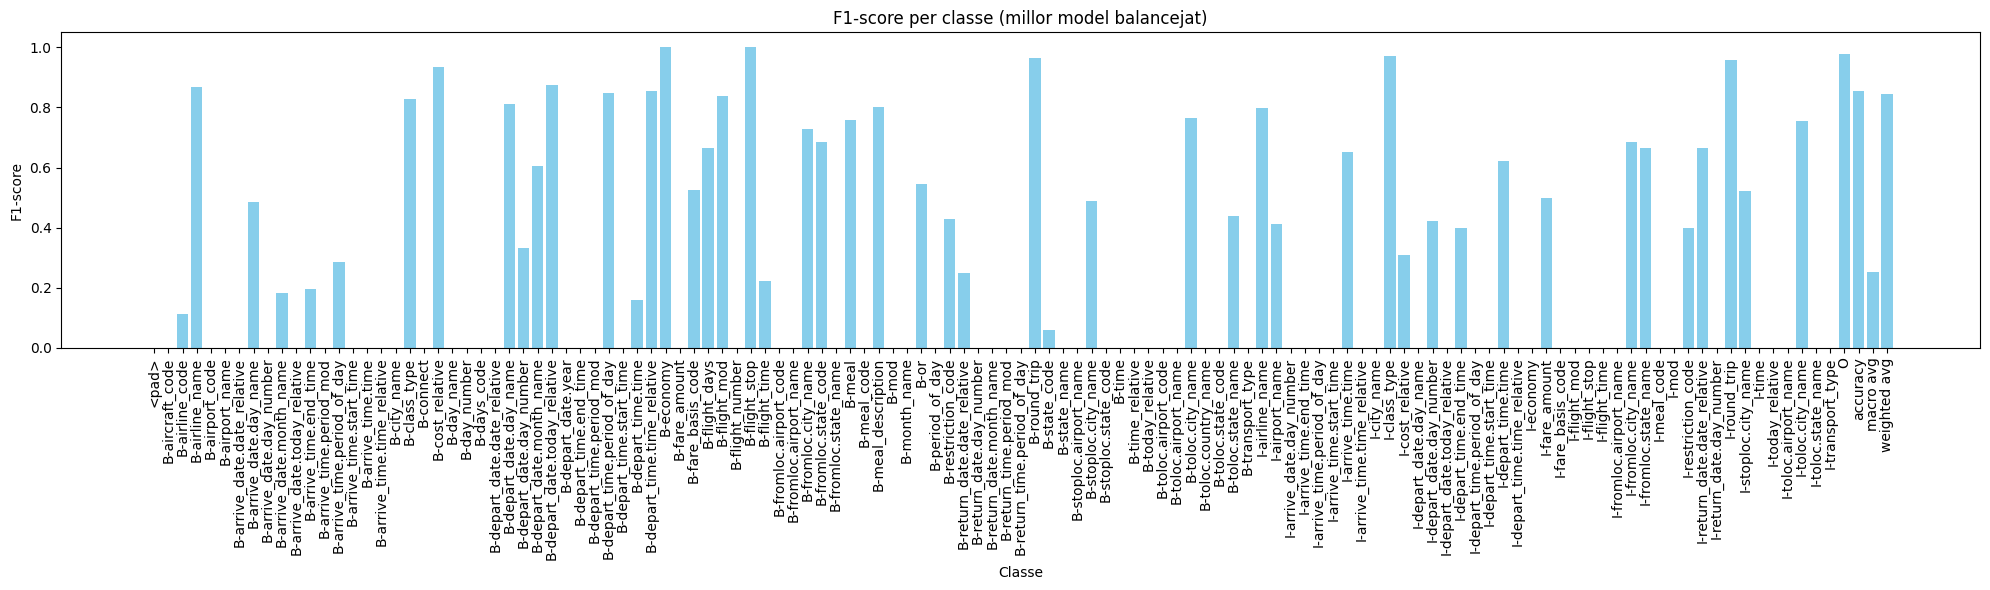

In [ ]:
plt.figure(figsize=(20,6))
plt.bar(df_report.index, df_report["f1-score"], color="skyblue")
plt.xticks(rotation=90)
plt.title("F1-score per classe (millor model balancejat)")
plt.xlabel("Classe")
plt.ylabel("F1-score")
plt.tight_layout()
plt.show()

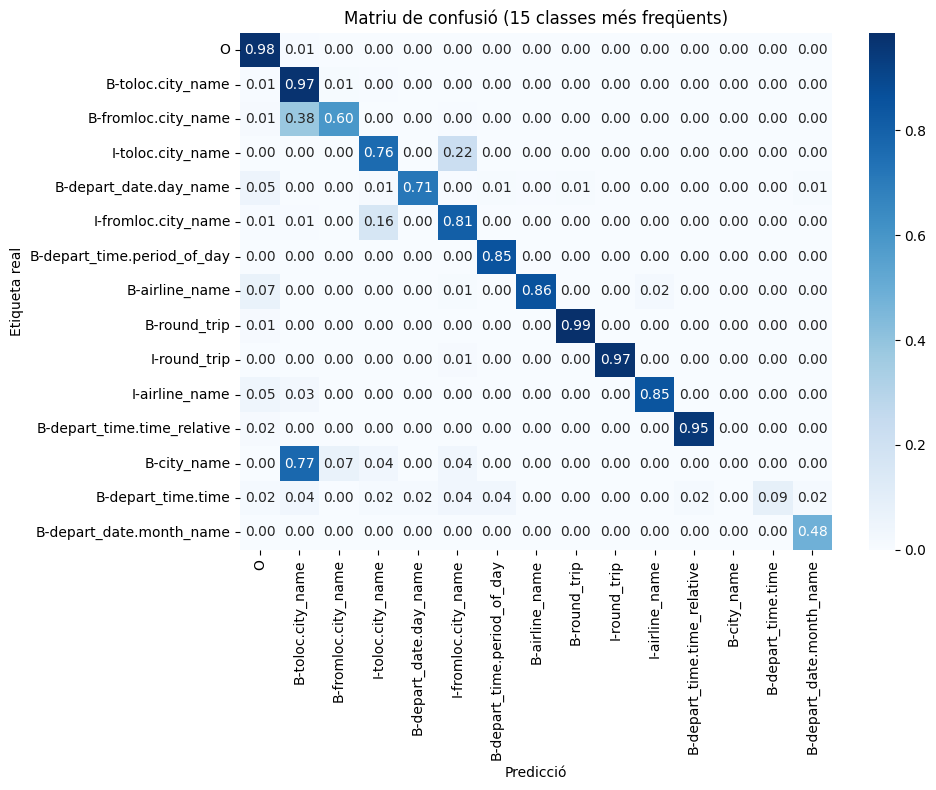

In [ ]:
cm = confusion_matrix(true_labels, pred_labels, labels=labels_sorted)
cm_norm = cm.astype("float") / (cm.sum(axis=1, keepdims=True) + 1e-6)

top_classes = np.argsort(-np.bincount(true_labels))[:15]
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm[top_classes][:, top_classes],
            annot=True, fmt=".2f", cmap="Blues",
            xticklabels=[label_names[i] for i in top_classes],
            yticklabels=[label_names[i] for i in top_classes])
plt.xlabel("Predicció")
plt.ylabel("Etiqueta real")
plt.title("Matriu de confusió (15 classes més freqüents)")
plt.tight_layout()
plt.show()

---

<h1><a name="section-four"> 4. Lliurable </a></h1>

Heu d'entregar un document PDF de com a **màxim 10 pàgines** que incloga els resultats de tots els exercicis així com una explicació de cadascun dels resultats i de la modificació que heu fet. L'estructura del document és:

1. Introducció.
2. Experiments i Resultats (amb raonament).
3. Conclusions.

No cal que afegiu el vostre codi al document, podeu entregar el *notebook* juntament amb el document.

 ---